# Introduction to the BART command-line tools

BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation.

In [1]:
# get a list of BART commands by running bart with no arguments:
bart

BART. Available commands are:
avg         bench       bitmask     cabs        caldir      calmat      
carg        casorati    cc          ccapply     cdf97       circshift   
conj        conv        copy        cpyphs      creal       crop        
delta       ecalib      ecaltwo     estdelay    estdims     estshift    
estvar      extract     fakeksp     fft         fftmod      fftrot      
fftshift    filter      flatten     flip        fmac        homodyne    
index       invert      itsense     join        lrmatrix    mandelbrot  
mip         nlinv       noise       normalize   nrmse       nufft       
ones        pattern     phantom     pics        pocsense    poisson     
poly        repmat      reshape     resize      rof         rss         
sake        saxpy       scale       sdot        show        slice       
spow        sqpics      squeeze     std         svd         threshold   
toimg       traj        transpose   twixread    var         vec         
version     walsh    

: 1

Before getting started, let's make a helper function for displaying images. We will use the BART command `toimg`, which can convert BART files to pngs. If our session supports X-windows forwarding, we can instead use the BART viewer, `view`, to open an interactive viewer

In [2]:
function imshow () {
    bart toimg -W $1 $1.png
    cat $1.png | display
    rm $1.png
}

In [3]:
bart toimg -h

Usage: toimg [-g f] [-c f] [-w f] [-d] [-m] [-W] [-h] <input> <output_prefix>

Create magnitude images as png or proto-dicom.
The first two non-singleton dimensions will
be used for the image, and the other dimensions
will be looped over.


-g gamma      	gamma level
-c contrast      	contrast level
-w window      	window level
-d		write to dicom format (deprecated, use extension .dcm)
-m		re-scale each image
-W		use dynamic windowing
-h		help


 ## How to use BART
 
As an example, let's first create a Shepp-Logan phantom in k-space. 

Writing 1 image(s)...done.


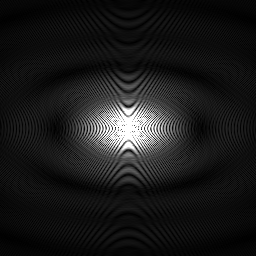

In [4]:
# Create Cartesian k-space phantom (256 samples)
bart phantom -x 256 -k shepp_logan

imshow shepp_logan
# view  shepp_logan

BART command structure:<br>
**bart** + **command** + **options** + **input / output**

To see all options and requirements of a command, use the '-h' flag:

In [5]:
# Obtain help for each command (-h)
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-x d] [-G d] [-3] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S Output nc sensitivities
-k		k-space
-t file      	trajectory
-x n      	dimensions in y and z
-G n=1,2      	Geometric object phantom
-3		3D
-h		help


All data files are multi-dimensional arrays.<br>
Next, we show the dimensions of the created Shepp-Logan phantom

In [6]:
bart show -m shepp_logan

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


By convention, the dimensions are `[X, Y, Z, C, M, T, C, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `C` are used for echo times and coefficient dimensions,   
and other higher order dimensions such as phase, flow encode, etc.

Let's reconstruct our k-space phantom. <br>
Therefore, we perform a Fast Fourier Transform (FFT).

Writing 1 image(s)...done.


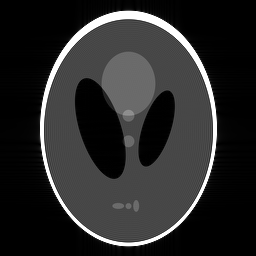

In [7]:
# Perform FFT reconstruction
bart fft -u -i 3 shepp_logan shepp_logan_rec
imshow shepp_logan_rec
# view shepp_logan_rec

Let's see the fft-options.

In [8]:
# Show help for fft command
bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output>

Performs a fast Fourier transform (FFT) along selected dimensions.

-u		unitary
-i		inverse
-n		un-centered
-h		help


Thus, we performed an inverse (-i) unitary (-u) Fast Fourier Transform on the image dimensions **(0, 1)** specified by the bitmask **3**.


BART data operates on bitmasks. To operate on a particular array dimension, a bitmask specifies the active dimensions.<br>
In our case, the bitmask is calculated as:<br>
<center>
$ \text{bitmask}=2^{~0} + 2^{~1} = 3$
</center> <br>
BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

In [9]:
# Calculate bitmask for active dimensions 0 and 1
bart bitmask 0 1

3


## BART Examples
### Low-Pass Filtering

Here, we create and apply a simple mask to low-pass filter the k-space phantom.

Writing 1 image(s)...done.


Writing 1 image(s)...done.


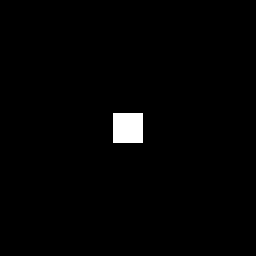

In [10]:
# Create a mask consisting of ones with two dimensions: (256, 100)
bart ones 2 30 30 mask_center

# Zero-pad the second (index 1) dimension to the full k-space dimension 
bart resize -c 0 256 1 256 mask_center mask_full

# view mask_center mask_full
imshow mask_center
imshow mask_full

Writing 1 image(s)...done.


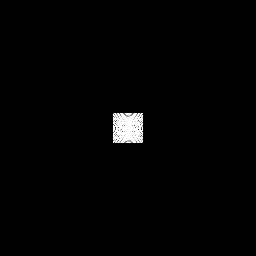

In [11]:
# Multiply mask with k-space
bart fmac shepp_logan mask_full shepp_logan_lp
imshow shepp_logan_lp
# view shepp_logan_lp

Writing 1 image(s)...done.


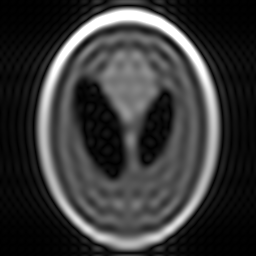

In [12]:
# Reconstruction of low-pass filtered k-space data
bart fft -u -i 3 shepp_logan_lp shepp_logan_lp_reco
imshow shepp_logan_lp_reco
# view shepp_logan_lp_reco

### Undersampling Artifacts

yes: standard output: Broken pipe
yes: standard output: Broken pipe
Writing 1 image(s)...done.


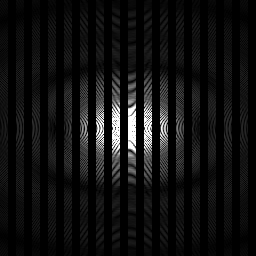

In [15]:
# Create Cartesian undersampling pattern (2x undersampling with 20 auto-calibration lines)

R=8 #Define undersampling factor as powers of 2

# Create local pattern, assuming homogeneous undersampling in one dimension
bart ones 2 256 1 ones
bart zeros 2 256 1 zeros
bart join 1 $(yes ones | head -n$R) $(yes zeros | head -n$R) pattern

# Repeat local pattern to get undersampling pattern
bart repmat 2 $((128/R)) pattern tmp
bart reshape $(bart bitmask 1 2) 256 1 tmp grid

# Multiply undersampling pattern with image
bart fmac shepp_logan grid shepp_us

imshow shepp_us

Writing 1 image(s)...done.


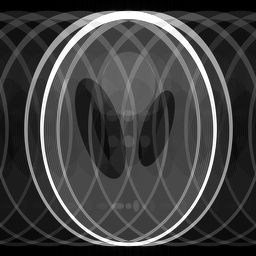

In [16]:
# Reconstruction of undersampled k-space data
bart fft -u -i 3 shepp_us shepp_us_reco
imshow shepp_us_reco

### Reconstruction of Multi-Coil Data
Now, let's create and reconstruct multi-coil data.

In [17]:
# Create a k-space phantom with multiple (8) coils
bart phantom -x 256 -s 8 -k shepp_coils

In [18]:
# Add Gaussian white noise to the k-space, multi-coil phantom
bart noise -n 2 shepp_coils shepp_noise

In [19]:
# Compress to 4 coils
bart cc -p 4 shepp_noise shepp_cc

Done.


In [20]:
# Reconstruct noisy phantom
bart fft -u -i $(bart bitmask 0 1) shepp_cc shepp

Writing 1 image(s)...done.


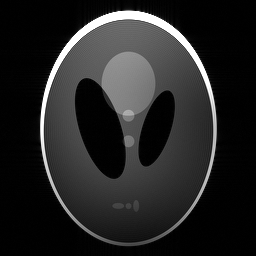

In [21]:
# Slice out one coil-image of the reconstructed k-space phantom and display.
bart slice 3 0 shepp shepp_coil0
imshow shepp_coil0

Writing 1 image(s)...done.


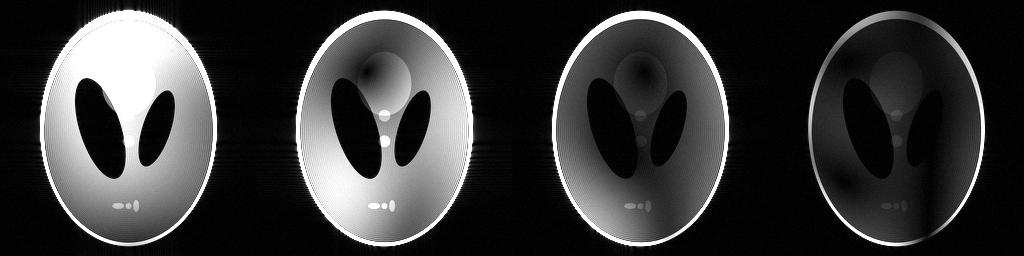

In [31]:
# Reshape the coil images for displaying. We will concatenate the row dimension with the coil dimension  
bart reshape `bart bitmask 1 3` 1024 1 shepp shepp_flat
imshow shepp_flat

Writing 1 image(s)...done.


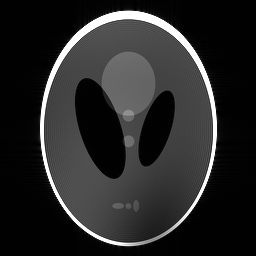

In [32]:
# Combine coils (Root-Sum-of-Squares)
bart rss $(bart bitmask 3) shepp shepp_rss
imshow shepp_rss
# view shepp_rss shepp_coil0

yes: standard output: Broken pipe
yes: standard output: Broken pipe


# Parallel Imaging Compressed Sensing

Done.
Writing 1 image(s)...done.


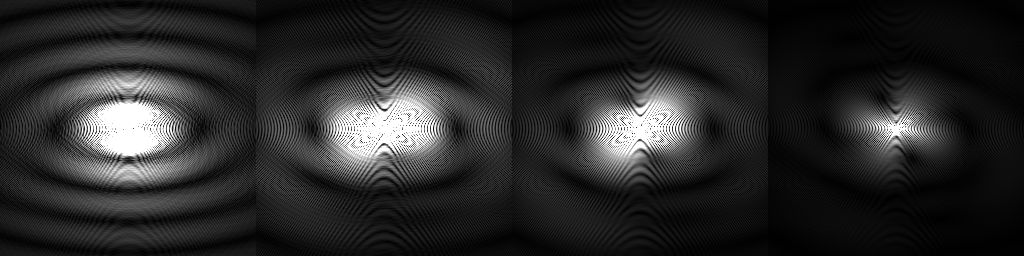

In [35]:
# Create k-space phantom (256x256 samples, 4 coils)
bart phantom -x 256 -k -s8 shepp1

# Compress to 4 coils
bart cc -p 4 shepp1 shepp

# Display k-space phantom
bart reshape `bart bitmask 1 3` 1024 1 shepp shepp_flat
imshow shepp_flat

points: 18218, grid size: 256x256 = 65536 (R = 3.597321)
Writing 1 image(s)...done.


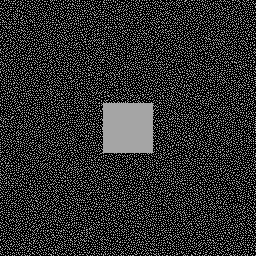

In [42]:
# Create Poisson-Disc undersampling pattern

# 2x2-fold in-plane acceleration. Auto-calibration region: 80x80
bart poisson -Y 256 -y 2 -Z 256 -z 2 -C 50 poisson1

# Reshape into required dimensions to match the k-space
bart reshape `bart bitmask 0 1 2` 256 256 1 poisson1 poisson

# Show pattern
imshow poisson

Writing 1 image(s)...done.


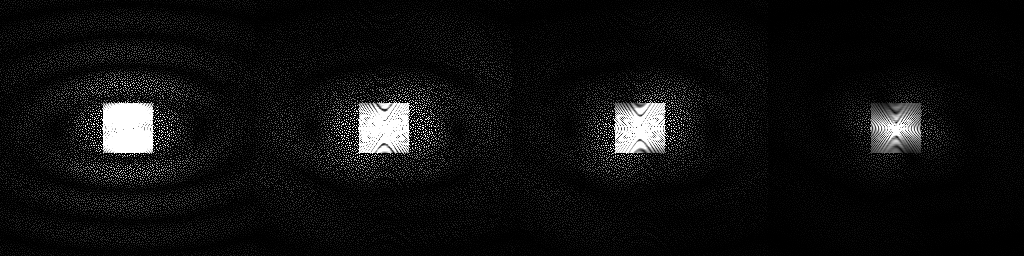

In [44]:
# Multiply pattern and k-space to obtain undersampled k-space
bart fmac shepp poisson shepp_usamp

# Show undersampled k-space phantom
bart reshape `bart bitmask 1 3` 1024 1 shepp_usamp shepp_usamp_flat
imshow shepp_usamp_flat

Note that the undersampling pattern was automatically applied to each coil!

Writing 1 image(s)...done.


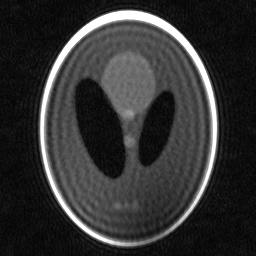

In [45]:
# Conventional FFT-reconstruction

# Perform conventional inverse FFT reconstruction
bart fft -i -u `bart bitmask 0 1` shepp_usamp shepp_fft

# Combine coils by Root-Sum-of-Squares
bart rss `bart bitmask 3` shepp_fft shepp_fft_rss

# Show FFT reconstruction
imshow shepp_fft_rss

Done.
Writing 1 image(s)...done.


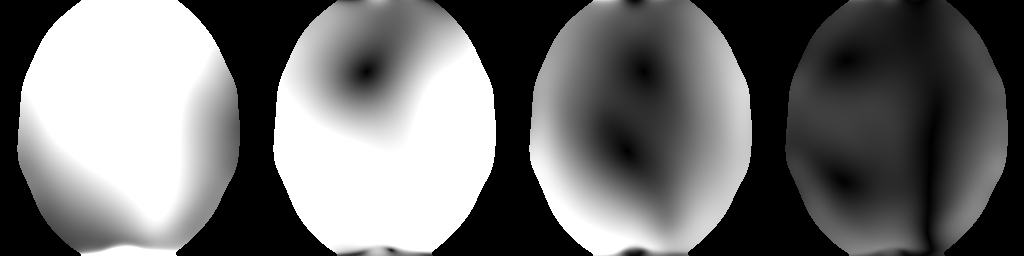

In [46]:
# Iterative Parallel Imaging Reconstruction with different regularization terms

# Compute sensitivity maps using ESPIRiT (constrained to a single map)
bart ecalib -m1 shepp_usamp sens

# Show sensitivity maps
bart reshape `bart bitmask 1 3` 1024 1 sens sens_flat
imshow sens_flat

Size: 65536 Samples: 18218 Acc: 3.60
l2 regularization: 0.005000
conjugate gradients
Total Time: 0.516021
Size: 65536 Samples: 18218 Acc: 3.60
l1-wavelet regularization: 0.005000
FISTA
Total Time: 0.616512
Writing 1 image(s)...done.


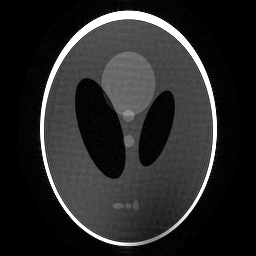

Writing 1 image(s)...done.


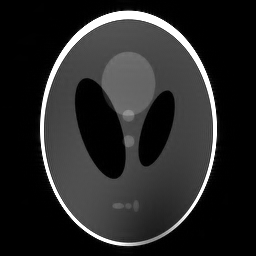

In [51]:
lambda=0.005
iter=50

# Parallel Imaging reconstruction using L2 regularization
bart pics -S -l2 -r$lambda -i $iter shepp_usamp sens shepp_l2

# Parallel Imaging Compressed Sensing reconstruction using WAVELET regularization
bart pics -S -R W:`bart bitmask 0 1`:0:$lambda -i $iter shepp_usamp sens shepp_wavelet

# Show L2 and Wavelet reconstructions
imshow shepp_l2
imshow shepp_wavelet